In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
import sys
sys.path.append('../src')
from utils import draw_graph2D


class ParametrizedSoftMax(torch.nn.Module):
    def __init__(self,alpha,dim:int) -> None:        
        torch.nn.Module.__init__(self)
        self.alpha = alpha
        self.dim = dim

    def forward(self,X):
        eX = torch.exp(-self.alpha*X)
        sm = eX/eX.sum(dim=self.dim,keepdim=True)
        return sm
    
def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist    

def computeMaxSpanningTreesBatch(Q,S):

    nV = Q.shape[1]

    grid = torch.arange(0, (nV)*(nV)).reshape(nV,nV).triu(1)

    triuIdx = grid[grid>0]

    seqS= torch.arange(0,S)

    def extractTriuAndFlatten(A):
        return A.reshape(S,nV*nV)[:, triuIdx]

    inTree = torch.zeros((S, nV, 1), dtype=torch.bool)
    inTree[:,nV-1] = True

    triuBool = (grid>0)
    Q_flat = Q.reshape([S, nV*nV])[:,triuIdx]

    A_trees= torch.zeros(S,nV,nV)

    for step in range(nV-1):

        validEdgeIdx = (inTree != torch.transpose(inTree,1,2)) & triuBool
        drawnEdgeIdx = triuIdx[ (Q_flat * extractTriuAndFlatten(validEdgeIdx)).argmax(1)]

        drawn_j = drawnEdgeIdx % nV
        drawn_i = (drawnEdgeIdx / nV).long()

        inTree[seqS,drawn_i]=True
        inTree[seqS,drawn_j]=True
        A_trees[seqS,drawn_i,drawn_j]= True
        A_trees[seqS,drawn_j,drawn_i]= True
    
    return A_trees

In [52]:
X = torch.rand(100,3)
y = torch.rand(100,3)

tensor([0.0233, 0.0070, 0.0064])
tensor([0.9865, 0.9946, 0.9789])
tensor([-1.2124e+00, -9.7780e-01,  6.7351e-04])
tensor([1.1880, 1.2163, 0.0489])


torch.Size([14580, 20])


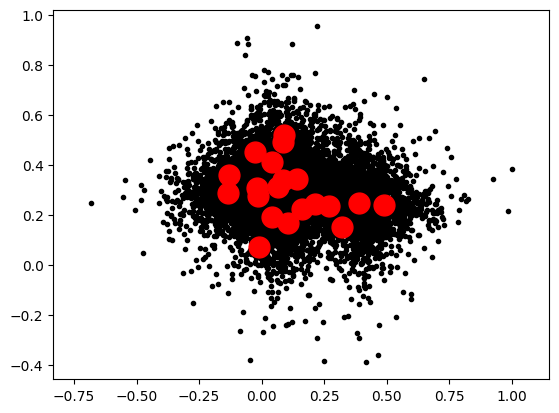

In [28]:
import random

A = torch.tensor([[0,1,1,1],
                  [1,0,0,0],
                  [1,0,0,0],
                  [1,0,0,0]],dtype=torch.float32)

if False:
    A = torch.tensor([[0,1,1,1,0,0,0],
                    [1,0,0,0,0,0,0],
                    [1,0,0,0,0,0,0],
                    [1,0,0,0,1,1,1],
                    [0,0,0,1,0,0,0],
                    [0,0,0,1,0,0,0],
                    [0,0,0,1,0,0,0]],dtype=torch.float32)

    A = torch.tensor([[0,1,1,1,0,0,0,1,1],
                    [1,0,0,0,0,0,0,0,0],
                    [1,0,0,0,0,0,0,0,0],
                    [1,0,0,0,1,1,1,0,0],
                    [0,0,0,1,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0,0],
                    [1,0,0,0,0,0,0,0,0],
                    [1,0,0,0,0,0,0,0,0]],dtype=torch.float32)


A = torch.eye(20)

torch.manual_seed(0)
np.random.seed(3)
#df = pd.read_csv('../data/tree_data.csv')
#df = pd.read_csv('../data/1_branch_3D.csv')
df = pd.read_csv('../data/test.csv')
#df = pd.read_csv('../data/Xlat.csv')
X = torch.tensor(df.to_numpy().astype(np.float32))
#min_vals = X.min(dim=0, keepdim=True)[0] 
#max_vals = X.max(dim=0, keepdim=True)[0]
#X =  (X - min_vals)/(max_vals - min_vals + 1e-8)*2.0-1.0
#perm = torch.randperm(X.size(0))
#X = X[perm]
#X = X[:100,:]
print(X.shape)
#y = torch.rand(A.shape[0],X.shape[1],requires_grad=True)
#y = torch.tensor(X.detach().numpy()[random.randint(0,A.shape[0]),:],requires_grad=True)
#lst = list(range(X.shape[0]))
perm = torch.randperm(X.size(0))
idx = perm[:A.shape[0]]
samples = X[idx]        
y =  torch.nn.Parameter(torch.tensor(samples.detach().numpy(),requires_grad=True))
#self.y =  torch.nn.Parameter(torch.tensor(samples.detach().numpy(),requires_grad=True))
#y =  torch.tensor(X.detach().numpy()[irx,:],requires_grad=True)
#mins = X.min(axis=0).values
#maxs = X.max(axis=0).values
#y = y*(maxs-mins)+mins
#y = torch.tensor(y,requires_grad=True)

draw_graph2D(X,y,A)

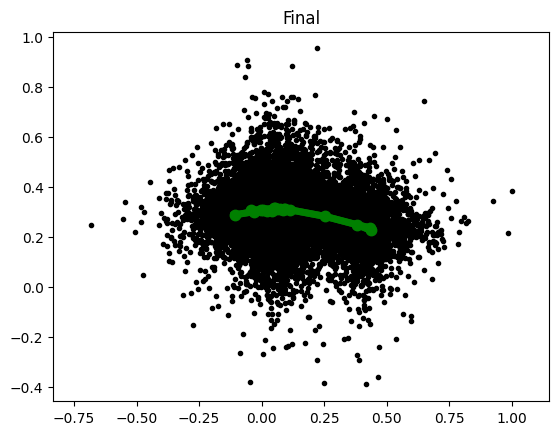

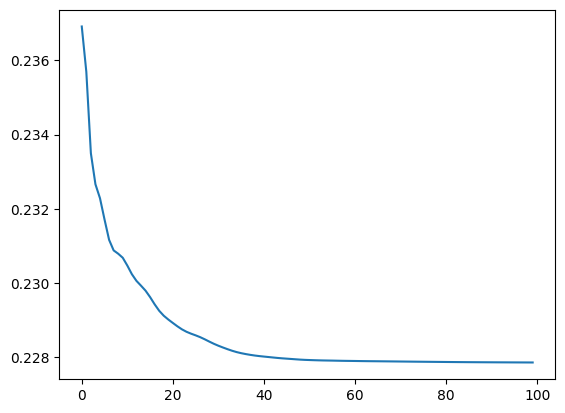

In [34]:
n = 1000
m = 3
k = 3
lm = 0.01
mu = 0.1
#sftmx = torch.nn.Softmax(dim=0)
#X = torch.rand(n,m)
#y = torch.rand(k,m,requires_grad=True)

learning_rate = 0.005
losses = []
#for alpha in np.arange(10.0,100.0,1.0):
alpha = 20.0
#for alpha in np.arange(10.0,-1.0,-1.0):
optim = torch.optim.Adam([y], learning_rate)
sftmx = ParametrizedSoftMax(alpha=alpha,dim=1)
numiter = 100

for i in range(numiter):
    dst = pairwise_distances(X,y)
    SA = sftmx(dst)
    lossMSE = (dst*SA).sum(dim=1).sum()/X.shape[0]
    loss = lossMSE

    assert not np.isnan(loss.detach())

    # sum of squared edge lengths
    edge_weights = torch.triu(A, diagonal=1)
    diff = y.unsqueeze(1) - y.unsqueeze(0)
    squared_diff = torch.sum(diff ** 2, dim=-1)
    sum_squared_length = torch.sum(squared_diff * edge_weights)    
    loss += lm*sum_squared_length

    # harmonicity term
    degrees = torch.sum(A, dim=1)
    mask = (degrees > 1).float()
    neighbor_sum = torch.matmul(A, y)
    avg_neighbour_position = torch.zeros_like(y)
    avg_neighbour_position[mask.bool()] = neighbor_sum[mask.bool()] / degrees[mask.bool()].unsqueeze(1)
    diff = y - avg_neighbour_position
    squared_distance_harmonic = torch.sum(diff ** 2, dim=1)
    squared_distance_harmonic = (squared_distance_harmonic * mask).sum()
    loss += mu*squared_distance_harmonic

    assert not np.isnan(loss.detach())

    #print(f'step={i+1},{lossMSE.item()=},{sum_squared_length.item()=},{squared_distance_harmonic.item()=}')

    optim.zero_grad()
    loss.backward(retain_graph=True)
    optim.step()
    losses.append(loss.item())

    sxn = sftmx(dst).detach().numpy()
    if False:
        draw_graph2D(X,y,A,title='Iteration: '+str(i+1)+',alpha='+str(alpha),drawX=False,show=False)
        #sns.scatterplot(x=X[:,0],y=X[:,1],color=sxn)
        sns.scatterplot(x=X[:,0],y=X[:,1])
        #if False:
        if i%10==0:
            clear_output(wait=True)
            time.sleep(3)
            plt.show()
        #plt.show()

    if i==numiter-1:
        draw_graph2D(X,y,A,title='Final',nodecolor='g',scale=0.5)


plt.plot(losses)
plt.show()



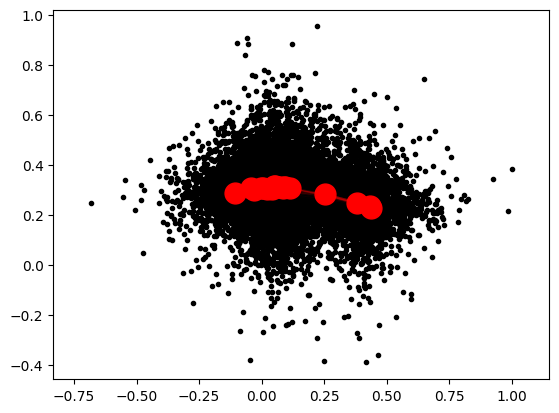

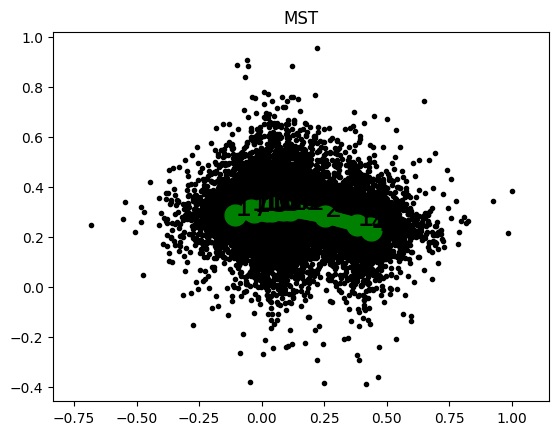

In [35]:
with torch.no_grad():
    sftmx = ParametrizedSoftMax(alpha=10,dim=1)
    ydst = pairwise_distances(y,y)
    v = torch.tensor([100]*ydst.shape[0])
    mask = torch.diag(torch.ones_like(v))
    ydst = mask*torch.diag(v) + (1. - mask)*ydst
    A = sftmx(ydst)
    A = (A+A.T)/2
    draw_graph2D(X,y,A)
    A2 = torch.zeros(2,A.shape[0],A.shape[1])
    A2[0,:,:] = A
    A2[1,:,:] = A
    A_tree = computeMaxSpanningTreesBatch(A2,2)[0,:,:]
    draw_graph2D(X,y,A_tree,nodecolor='g',title='MST',show=False)  
    for i,yi in enumerate(y):
        plt.text(yi[0].detach().numpy(),yi[1].detach().numpy(),str(i),fontsize=20)
    plt.show()  
    A = A_tree

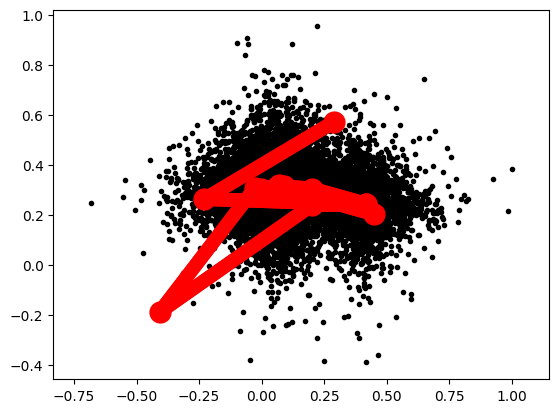

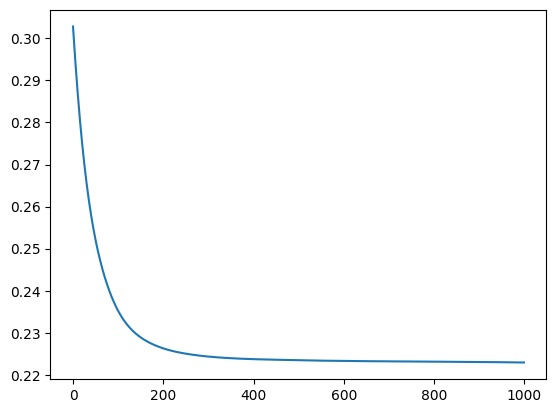

In [39]:
class ParametrizedSoftMax(torch.nn.Module):
    def __init__(self,alpha,dim:int) -> None:        
        torch.nn.Module.__init__(self)
        self.alpha = alpha
        self.dim = dim

    def forward(self,X):
        X = X + torch.min(X)
        X = torch.clamp(X, min=0.0, max=5.0)        
        eX = torch.exp(-self.alpha*X)
        sm = eX/eX.sum(dim=self.dim,keepdim=True)
        return sm


n = 1000
m = 3
k = 3
lm = 0.01
mu = 0.1
#sftmx = torch.nn.Softmax(dim=0)
#X = torch.rand(n,m)
#y = torch.rand(k,m,requires_grad=True)

learning_rate = 0.001
losses = []
#for alpha in np.arange(10.0,100.0,1.0):
alpha = 20.0
#for alpha in np.arange(10.0,-1.0,-1.0):
sftmx = ParametrizedSoftMax(alpha=alpha,dim=1)
numiter = 1000

X1 = X.clone()
#X1 = X1[:,:2]
#X1 = X1 - torch.max(X1)

perm = torch.randperm(X1.size(0))
idx = perm[:A.shape[0]]
samples = X1[idx]        
y =  torch.nn.Parameter(torch.tensor(samples.detach().numpy(),requires_grad=True))

#draw_graph2D(X1,y,A)

optim = torch.optim.Adam([y], learning_rate)


for i in range(numiter):
    dst = pairwise_distances(X1,y)
    SA = sftmx(dst)
    lossMSE = (dst*SA).sum(dim=1).sum()/X1.shape[0]
    loss = lossMSE

    assert not np.isnan(loss.detach())
    #print(i,loss.item())

    y1 = y.clone()

    optim.zero_grad()
    loss.backward(retain_graph=True)
    optim.step()
    losses.append(loss.item())

    #draw_graph2D(X1,y,A)


draw_graph2D(X1,y,A)

plt.plot(losses)
plt.show()



In [307]:
X1 = X.clone()
print(X1.std())
lst = list(range(X1.shape[0]))
irx = random.sample(lst, A.shape[0])
y =  torch.tensor(X1.detach().numpy()[irx,:],requires_grad=True)
dst = pairwise_distances(X1,y)

dst1 = dst.clone()
dst1 = dst1 + torch.min(dst1)
dst1 = torch.clamp(dst1, min=0.0, max=10.0)


print(dst1.shape,dst1.min(),dst1.max())

alpha = 10.0
eX = torch.exp(-alpha*dst1)
print(torch.isnan(eX).sum(),torch.isinf(eX).sum())
#sm = eX/eX.sum(dim=1,keepdim=True)
sm = eX.sum(dim=1,keepdim=True)
print(torch.isnan(sm).sum(),torch.isinf(sm).sum(),(sm==0.0).sum(dim=0))
sm = eX/eX.sum(dim=1,keepdim=True)
print(torch.isnan(sm).sum(),torch.isinf(sm).sum())


tensor(0.9924)
torch.Size([14580, 20]) tensor(0., grad_fn=<MinBackward1>) tensor(10., grad_fn=<MaxBackward1>)
tensor(0) tensor(0)
tensor(0) tensor(0) tensor([0])
tensor(0) tensor(0)


(array([42347., 44934., 36856., 29962., 24184., 18938., 14869., 11716.,
         9764., 58030.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

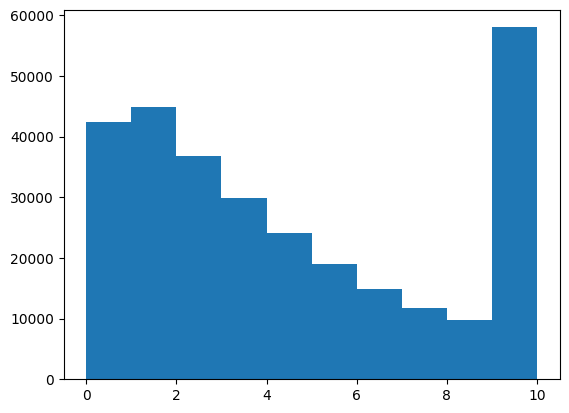

In [306]:
plt.hist(dst1.detach().ravel())

In [280]:
t = torch.tensor(np.arange(-1000.0,1000.0,100.0))
print(torch.exp(-t))

tensor([        inf,         inf,         inf, 1.0142e+304, 3.7730e+260,
        1.4036e+217, 5.2215e+173, 1.9424e+130,  7.2260e+86,  2.6881e+43,
         1.0000e+00,  3.7201e-44,  1.3839e-87, 5.1482e-131, 1.9152e-174,
        7.1246e-218, 2.6504e-261, 9.8597e-305,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64)


(array([1.83923e+05, 7.01150e+04, 2.25330e+04, 9.28900e+03, 4.10200e+03,
        1.23200e+03, 3.24000e+02, 6.70000e+01, 1.30000e+01, 2.00000e+00]),
 array([-60.01823044, -54.01640701, -48.01458359, -42.01276016,
        -36.01093674, -30.00911522, -24.00729179, -18.00546837,
        -12.0036459 ,  -6.00182295,   0.        ]),
 <BarContainer object of 10 artists>)

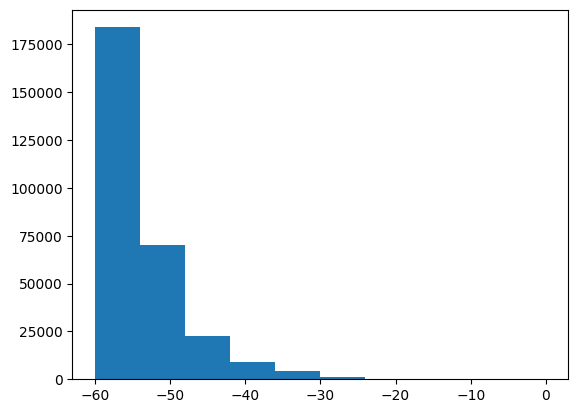

In [267]:
plt.hist(dst1.detach().ravel())

ValueError: supplied range of [3.5904847148579626e+23, inf] is not finite

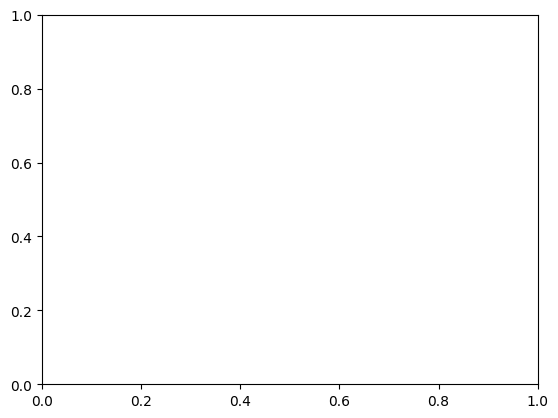

In [226]:
plt.hist(sm.ravel())

tensor(120)
tensor(nan, grad_fn=<DivBackward0>)


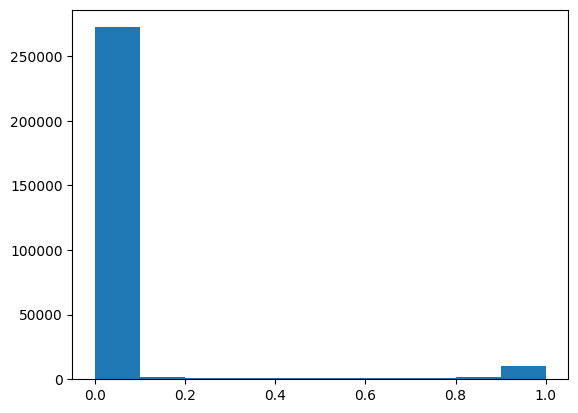

In [203]:
plt.hist((SA).detach().ravel())
print(torch.isnan(SA).sum())
lossMSE = (dst*SA).sum(dim=1).sum()/X1.shape[0]
print(lossMSE)

In [196]:
print(y)

tensor([[ 6.6091e-01,  5.9995e-02, -7.5706e-01],
        [-5.0165e-02,  4.7602e-01,  8.1702e-01],
        [-7.3940e-01, -1.3198e-02,  5.1895e-01],
        [-1.5374e-01,  3.9288e-01, -3.3868e-02],
        [-1.2249e+00, -1.5567e-01,  8.2120e-01],
        [ 8.8532e-01, -1.0689e+00,  1.2787e-01],
        [-3.0870e+00,  9.1673e-01,  4.2929e-01],
        [ 1.3981e-02,  8.4735e-01,  2.0212e-01],
        [-6.5589e-01,  2.4056e+00,  1.2753e+00],
        [ 2.7306e-02, -9.1216e-02,  1.7594e-03],
        [-1.2595e+00, -3.8934e-04, -1.9523e+00],
        [ 1.6313e+00, -1.9367e+00, -1.0258e+00],
        [-2.3297e+00,  8.0029e-01,  3.6749e-01],
        [ 6.2076e-01,  2.0834e-01, -1.0063e+00],
        [ 2.5875e+00, -2.2024e-01,  6.7735e-01],
        [ 1.3509e+00, -1.0063e+00, -3.4254e-02],
        [-1.5089e+00, -2.2223e-01,  7.5230e-01],
        [-1.1149e+00, -1.7311e-02,  6.7238e-01],
        [ 2.8067e-01, -6.3838e-01, -1.8312e+00],
        [ 1.7813e+00, -1.9924e+00, -9.7818e-01]], requires_grad=True)

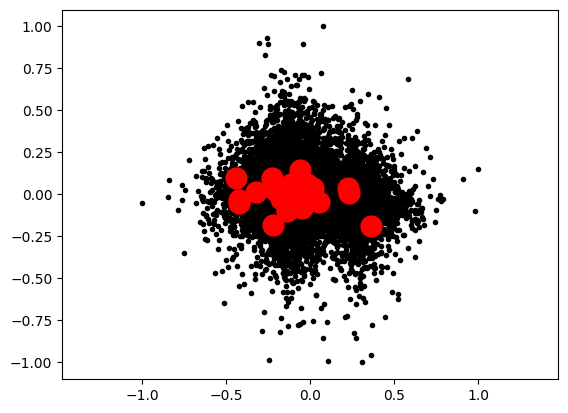

tensor([[1.1347, 1.0827, 0.6887,  ..., 0.7233, 0.6138, 1.0472],
        [2.1315, 1.5189, 1.8765,  ..., 1.2518, 1.2222, 1.4345],
        [1.8176, 1.0157, 1.1361,  ..., 1.1879, 0.8648, 1.4941],
        ...,
        [2.9463, 1.4795, 2.3413,  ..., 1.6519, 1.4136, 2.0032],
        [2.0673, 1.3910, 1.5030,  ..., 1.5375, 1.3645, 1.9414],
        [1.8559, 1.2574, 1.0228,  ..., 0.7891, 0.7176, 1.4449]],
       grad_fn=<SubBackward0>)


In [112]:
lst = list(range(X1.shape[0]))
irx = random.sample(lst, A.shape[0])
y =  torch.tensor(X1.detach().numpy()[irx,:],requires_grad=True)

draw_graph2D(X1,y,A)

dst = pairwise_distances(X1,y)
print(dst)

In [137]:
lossMSE = (dst*SA).sum(dim=1).sum()/X.shape[0]
print(lossMSE)

tensor(0.5353, grad_fn=<DivBackward0>)


In [176]:
torch.isnan(y1).sum()

tensor(0)

In [126]:
SA = sftmx(dst)
print(dst.shape,SA.shape)


torch.Size([14580, 20]) torch.Size([14580, 20])


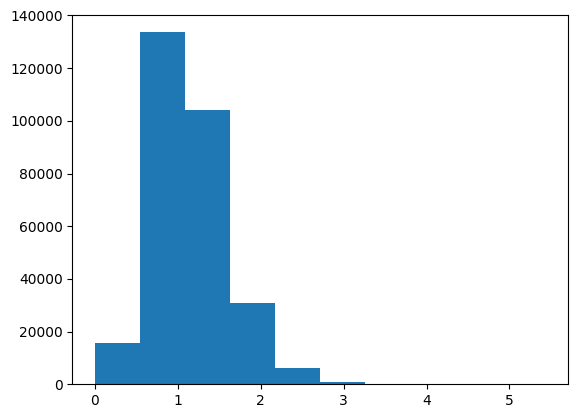

In [113]:
plt.hist(dst.flatten().detach())
plt.show()

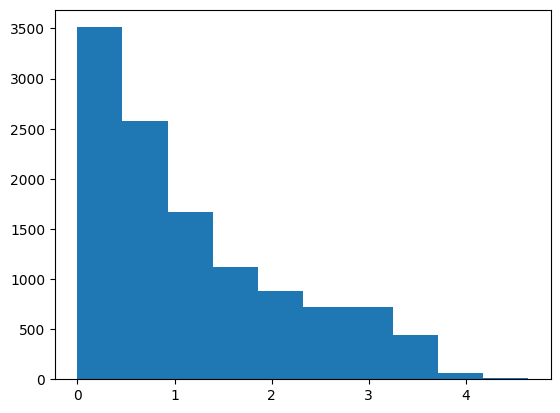

In [94]:
plt.hist((dst.flatten()/dst.std()).detach())
plt.show()
print()